In [1]:
from __future__ import print_function
from six.moves import range

import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity,euclidean_distances,cosine_distances
import time
import sys
import warnings
import os
import pickle
import pandas as pd
import PIL
from tqdm import tqdm_notebook
from keras.applications.inception_v3 import preprocess_input
os.environ["CUDA_VISIBLE_DEVICES"] = "1"
if not sys.warnoptions:
    warnings.simplefilter("ignore")
import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
import torch.backends.cudnn as cudnn
from miscc.config import cfg, cfg_from_file
from PIL import Image
import datetime
import dateutil.tz
from datasets import TextDataset
from miscc.utils import mkdir_p
from miscc.utils import build_super_images, build_super_images2
from miscc.utils import weights_init, load_params, copy_G_params
from model import G_DCGAN, G_NET
from datasets import prepare_data
from model import TEXT_TRANSFORMER_ENCODERv2, CNN_ENCODER
# from InceptionScore import calculate_inception_score
from miscc.losses import words_loss
from miscc.losses import discriminator_loss, generator_loss, KL_loss
import torchvision.transforms as transforms
from scipy.linalg import sqrtm

Using TensorFlow backend.
/home/mshaikh2/anaconda3/envs/pytorch-gpu/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/mshaikh2/anaconda3/envs/pytorch-gpu/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/mshaikh2/anaconda3/envs/pytorch-gpu/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])

In [14]:
root = '../data/rep_eval/'
clabel_texts = sorted(os.listdir('../data/rep_eval/'))

In [5]:
# def cosine_similarity(x1, x2, dim=1, eps=1e-8):
#     """Returns cosine similarity between x1 and x2, computed along dim.
#     """
#     w12 = np.sum(x1 * x2, dim)
#     w1 = np.linalg.norm(x1, 2, dim)
#     w2 = np.linalg.norm(x2, 2, dim)
#     return (w12 / np.clip(w1 * w2,a_min=eps,a_max=1e8)).squeeze()

In [6]:
class parse_args():
    cfg_file='../code/cfg/coco_attn2.yml'
    gpu_id=0
    data_dir='../data/coco/'
    manualSeed=1
args = parse_args()

In [7]:
def w2i(w=''):
    return [i for i, val in enumerate(np.array(clabel_texts)==w) if val]
def id2imgidx(i=0):
    return [i for i, val in enumerate(y_test==i) if val]
def fid(act1,act2):
    mu1, sigma1 = act1.mean(axis=0), np.cov(act1, rowvar=False)
    mu2, sigma2 = act2.mean(axis=0), np.cov(act2, rowvar=False)
    # calculate sum squared difference between means
    ssdiff = np.sum((mu1 - mu2)**2.0)
    # calculate sqrt of product between cov
    covmean = sqrtm(sigma1.dot(sigma2))
    # check and correct imaginary numbers from sqrt
    if np.iscomplexobj(covmean):
        covmean = covmean.real
    # calculate score
    fid = ssdiff + np.trace(sigma1 + sigma2 - 2.0 * covmean)
    return fid

In [8]:
args = parse_args()
if args.cfg_file is not None:
    cfg_from_file(args.cfg_file)

if args.gpu_id == -1:
    cfg.CUDA = False
else:
    cfg.GPU_ID = args.gpu_id

if args.data_dir != '':
    cfg.DATA_DIR = args.data_dir
    

print('Using config:')
display(cfg)

split_dir, bshuffle = 'train', True
if not cfg.TRAIN.FLAG:
    # bshuffle = False
    split_dir = 'test'

Using config:


{'DATASET_NAME': 'coco',
 'CONFIG_NAME': 'glu-gan2',
 'DATA_DIR': '../data/coco/',
 'GPU_ID': 0,
 'CUDA': True,
 'WORKERS': 4,
 'RNN_TYPE': 'LSTM',
 'B_VALIDATION': False,
 'TREE': {'BRANCH_NUM': 3, 'BASE_SIZE': 64},
 'TRAIN': {'BATCH_SIZE': 14,
  'MAX_EPOCH': 150,
  'SNAPSHOT_INTERVAL': 2,
  'DISCRIMINATOR_LR': 0.0002,
  'GENERATOR_LR': 0.0002,
  'ENCODER_LR': 0.0002,
  'RNN_GRAD_CLIP': 0.25,
  'FLAG': True,
  'NET_E': '../DAMSMencoders/coco/text_encoder240.pth',
  'NET_G': '../output/coco_glu-gan2_2020_10_25_15_48_15/Model/netG_epoch_130.pth',
  'B_NET_D': True,
  'SMOOTH': {'GAMMA1': 4.0, 'GAMMA3': 10.0, 'GAMMA2': 5.0, 'LAMBDA': 50.0}},
 'GAN': {'DF_DIM': 96,
  'GF_DIM': 48,
  'Z_DIM': 100,
  'CONDITION_DIM': 100,
  'R_NUM': 3,
  'B_ATTENTION': True,
  'B_DCGAN': False},
 'TEXT': {'CAPTIONS_PER_IMAGE': 5, 'EMBEDDING_DIM': 256, 'WORDS_NUM': 15}}

In [9]:
imsize = cfg.TREE.BASE_SIZE * (2 ** (cfg.TREE.BRANCH_NUM-1))
imsize*76/64

304.0

In [10]:
imsize = cfg.TREE.BASE_SIZE * (2 ** (cfg.TREE.BRANCH_NUM - 1))
image_transform = transforms.Compose([
    transforms.Scale(int(imsize * 76 / 64)),
    transforms.RandomCrop(imsize),
    transforms.RandomHorizontalFlip()])
dataset = TextDataset(cfg.DATA_DIR, split_dir,
                      base_size=cfg.TREE.BASE_SIZE,
                      transform=image_transform)
assert dataset

Load filenames from: ../data/coco//train/filenames.pickle (82783)
Load filenames from: ../data/coco//test/filenames.pickle (40470)
Load from:  ../data/coco/captions.pickle
../data/coco/train


In [11]:
if cfg.TRAIN.NET_G == '':
    print('Error: the path for generator models is not found!')
else:
    
    # Build and load the generator
    if cfg.GAN.B_DCGAN:
        netG = G_DCGAN()
    else:
        netG = G_NET()
    netG.apply(weights_init)
    netG.cuda()
    netG.eval()
    #
    text_encoder = TEXT_TRANSFORMER_ENCODERv2(emb=cfg.TEXT.EMBEDDING_DIM
                                    ,heads=8
                                    ,depth=1
                                    ,seq_length=cfg.TEXT.WORDS_NUM
                                    ,num_tokens=dataset.n_words)
    state_dict = \
        torch.load(cfg.TRAIN.NET_E, map_location=lambda storage, loc: storage)
    text_encoder.load_state_dict(state_dict)
    print('Load text encoder from:', cfg.TRAIN.NET_E)
    text_encoder = text_encoder.cuda()
    text_encoder.eval()

    image_encoder = CNN_ENCODER(cfg.TEXT.EMBEDDING_DIM)
    img_encoder_path = cfg.TRAIN.NET_E.replace('text_encoder', 'image_encoder')
    state_dict = \
        torch.load(img_encoder_path, map_location=lambda storage, loc: storage)
    image_encoder.load_state_dict(state_dict)
    for p in image_encoder.parameters():
        p.requires_grad = False
    print('Load image encoder from:', img_encoder_path)
    image_encoder.eval()


Load text encoder from: ../DAMSMencoders/coco/text_encoder240.pth
Load pretrained model from  https://download.pytorch.org/models/inception_v3_google-1a9a5a14.pth
Load image encoder from: ../DAMSMencoders/coco/image_encoder240.pth


In [115]:
clabel_texts

['airplane',
 'apple',
 'backpack',
 'banana',
 'baseball bat',
 'baseball glove',
 'bear',
 'bed',
 'bench',
 'bicycle',
 'bird',
 'boat',
 'book',
 'bottle',
 'bowl',
 'broccoli',
 'bus',
 'cake',
 'car',
 'carrot',
 'cat',
 'cell phone',
 'chair',
 'clock',
 'couch',
 'cow',
 'cup',
 'dining table',
 'dog',
 'donut',
 'elephant',
 'fire hydrant',
 'fork',
 'frisbee',
 'giraffe',
 'hair drier',
 'handbag',
 'horse',
 'hot dog',
 'keyboard',
 'kite',
 'knife',
 'laptop',
 'microwave',
 'motorcycle',
 'mouse',
 'orange',
 'oven',
 'parking meter',
 'person',
 'pizza',
 'potted plant',
 'refrigerator',
 'remote',
 'sandwich',
 'scissors',
 'sheep',
 'sink',
 'skateboard',
 'skis',
 'snowboard',
 'spoon',
 'sports ball',
 'stop sign',
 'suitcase',
 'surfboard',
 'teddy bear',
 'television',
 'tennis racket',
 'tie',
 'toaster',
 'toilet',
 'toothbrush',
 'traffic light',
 'train',
 'truck',
 'umbrella',
 'vase',
 'wine glass',
 'zebra']

In [116]:
idx = 2
clabel_texts[idx]


'backpack'

In [138]:
img_folder  = os.path.join(root,'stop sign')
img_list = os.listdir(img_folder)

In [139]:
# selected_id = w2i('aquarium_fish')[0]
# ids = id2imgidx(selected_id)

In [140]:
imgs = []
for im in img_list:
    imgs.append(np.asarray(Image.open(os.path.join(img_folder,im)).convert('RGB').resize((299,299),PIL.Image.ANTIALIAS),dtype=np.int32))
imgs = np.array(imgs)

In [141]:
imgs.min(),imgs.max()

(0, 255)

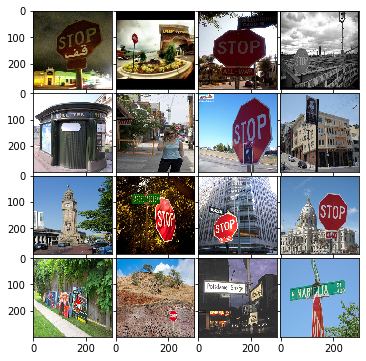

backpack


In [142]:


im1 = np.arange(100).reshape((10, 10))
im2 = im1.T
im3 = np.flipud(im1)
im4 = np.fliplr(im2)

fig = plt.figure(figsize=(6., 6.))
grid = ImageGrid(fig, 111,  # similar to subplot(111)
                 nrows_ncols=(4, 4),  # creates 2x2 grid of axes
                 axes_pad=0.05,  # pad between axes in inch.
         )

for ax, im in zip(grid,imgs[:16]):
    # Iterating over the grid returns the Axes.
    ax.imshow(im)

plt.show()
print(clabel_texts[idx])

In [47]:
imgs = preprocess_input(x_test[ids])

In [48]:
imgs.min(),imgs.max()

(-1.0, 1.0)

In [49]:
print(imgs.shape)
i = np.rollaxis(imgs,axis=3,start=1)
i = np.asarray(i,dtype=np.float32)
print(i.shape)

(100, 32, 32, 3)
(100, 3, 32, 32)


In [50]:
img_inp = torch.tensor(i)

In [51]:
r_emb, i_emb = image_encoder(img_inp)

In [52]:
r_emb.shape,i_emb.shape

(torch.Size([100, 256, 17, 17]), torch.Size([100, 256]))

In [53]:
i_emb = np.asarray(i_emb.detach().cpu())


In [83]:
selected_id = w2i('bus')[0]
print(selected_id)
print(clabel_texts[selected_id])
t_inp = [dataset.wordtoix[x] for x in [clabel_texts[selected_id]]]
text_inp = torch.tensor(np.array([t_inp])).cuda()
print(text_inp)

13
bus
tensor([[63]], device='cuda:0')


In [84]:
w_emb,s_emb = text_encoder(text_inp)

In [85]:
w_emb.shape, s_emb.shape

(torch.Size([1, 256, 1]), torch.Size([1, 256]))

In [86]:
s_emb = np.asarray(s_emb.detach().cpu())


In [87]:
s_emb.shape,i_emb.shape

((1, 256), (100, 256))

In [88]:
# [x for x in zip(emb,w_emb[0])]

In [89]:
sims = []
for emb in i_emb:
    sims.append(cosine_similarity([emb],s_emb))
# sims

In [90]:
fid(s_emb,np.array(i_emb))

658.765511474636

In [91]:
df = pd.DataFrame()
df['sims'] = [float(x) for x in sims]

In [130]:
# list(sims)
df.describe()

sims
count  100.000000
mean     0.240041
std      0.071597
min      0.043602
25%      0.189629
50%      0.235504
75%      0.291160
max      0.389651

In [100]:
df.describe().T['mean'].values[0]

-0.03780492545105517

In [348]:
word_feats = {}
for w in tqdm_notebook(clabel_texts,leave=False):
    if ' ' in w:
        w_ = w.split(' ')
    else:
        w_ = [w]
    if w_[0] in keys:
        result[word+'_img'][w] = {}
        t_inp = [dataset.wordtoix[x] for x in w_]
        text_inp = torch.tensor(np.array([t_inp])).cuda()
        w_emb,s_emb = text_encoder(text_inp)
        s_emb = np.asarray(s_emb.detach().cpu())
        word_feats[w] = s_emb

# P, R, F

In [349]:
keys = list(dataset.wordtoix.keys())
result = {}
img_emb = {}
for word in tqdm_notebook(clabel_texts):
    if ' ' in word:
        word_ = word.split(' ')[1]
    else:
        word_ = word
    if word_ in keys:
        result[word+'_img']={}        
        img_folder  = os.path.join(root,word)
        img_list = os.listdir(img_folder)
        imgs = []
        for im in img_list:
            try:
                imgs.append(np.asarray(Image.open(os.path.join(img_folder,im)).convert('RGB').resize((299,299),PIL.Image.ANTIALIAS),dtype=np.int32))
            except Exception as ex:
                pass
        imgs = np.array(imgs)
        imgs = preprocess_input(imgs)
        i = np.rollaxis(imgs,axis=3,start=1)
        i = np.asarray(i,dtype=np.float32)
        img_inp = torch.tensor(i)
        r_emb, i_emb = image_encoder(img_inp)
        i_emb = np.asarray(i_emb.detach().cpu())  
        img_emb[word] = i_emb

#         for w in tqdm_notebook(clabel_texts,leave=False):
#             if ' ' in w:
#                 w_ = w.split(' ')
#             else:
#                 w_ = [w]
#             if w_[0] in keys:
#                 result[word+'_img'][w] = {}
#                 t_inp = [dataset.wordtoix[x] for x in w_]
#                 text_inp = torch.tensor(np.array([t_inp])).cuda()
#                 w_emb,s_emb = text_encoder(text_inp)
#                 s_emb = np.asarray(s_emb.detach().cpu())
#                 sims = []
#                 for emb in i_emb:
#                     sims.append(cosine_similarity([emb],s_emb))
#                 df = pd.DataFrame()
#                 df['sims'] = [float(x) for x in sims]
#                 result[word+'_img'][w]['c_sim_mean'] = np.around(df.describe().T['mean'].values[0],4)
#                 result[word+'_img'][w]['c_sim_std'] = np.around(df.describe().T['std'].values[0],4)
#                 result[word+'_img'][w]['fid'] = np.around(fid(s_emb,np.array(i_emb)),4)

In [379]:
all_classes = np.array(list(img_emb.keys()))

In [449]:
len(word_feats.items())

80

In [436]:
confusion_matrix=np.zeros((len(all_classes),len(all_classes)))
confusion_matrix.shape

(80, 80)

In [493]:
row,col = -1, -1
confusion_matrix=np.zeros((len(all_classes),len(all_classes)))
confusion_matrix.shape
for kt,vt in tqdm_notebook(img_emb.items()):
    true_label = kt
    ies = img_emb[kt]    
    row+=1
    for ie in tqdm_notebook(ies,leave=False): # 100 images
        preds = []
        for k,v in word_feats.items():
            target_class = k
            we = word_feats[k]
#             print(cosine_similarity([ie],we)[0][0])
            preds.append(cosine_similarity([ie],we)[0][0]) # 80 words
        
        pred_class = np.asarray(preds).argmax(-1)
#         print(pred_class)
        confusion_matrix[row][pred_class]+=1
#         break
#     break


In [487]:
confusion_matrix

array([[100.,   0.,   0., ...,   0.,   0.,   0.],
       [  0.,  83.,   0., ...,   0.,   0.,   0.],
       [  0.,   0.,   8., ...,   0.,   0.,   0.],
       ...,
       [  0.,   2.,   0., ...,  85.,   7.,   0.],
       [  0.,   1.,   0., ...,   0.,  85.,   0.],
       [  0.,   0.,   0., ...,   0.,   0.,  96.]])

# C-SIM, FID

In [553]:
confusion_matrix[1,:][1],np.sum(confusion_matrix[1,:])-83

(83.0, 17.0)

78.5 0.5


Text(78.625, 0.5, 'True')

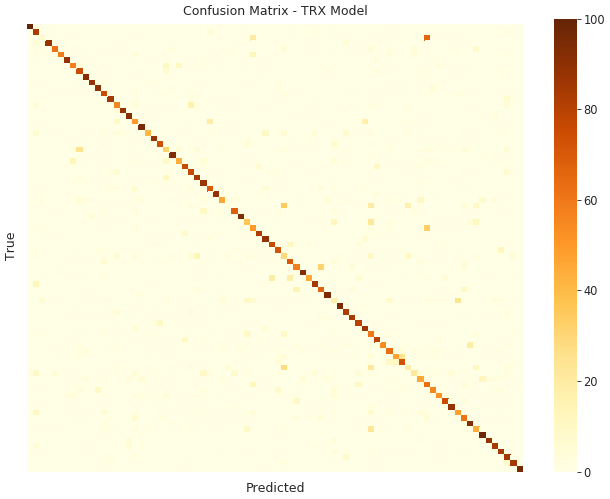

In [635]:
import seaborn as sns
['Greys', 'Purples', 'Blues', 'Greens', 'Oranges', 'Reds',
            'YlOrBr', 'YlOrRd', 'OrRd', 'PuRd', 'RdPu', 'BuPu',
            'GnBu', 'PuBu', 'YlGnBu', 'PuBuGn', 'BuGn', 'YlGn']
# sns.set(rc={'figure.figsize':(16.0,13)})
sns.set_theme(style='white',font_scale=1.5)

fig, ax = plt.subplots(1, 1, figsize = (16, 12), dpi=50)

# uniform_data = np.random.rand(10, 12)

ax = sns.heatmap(confusion_matrix
                 , annot=False
                 , cmap='YlOrBr')
bottom, top = ax.get_ylim()
print(bottom,top)
ax.set_ylim(bottom + 1.5, top - 1.5)
ax.set_title('Confusion Matrix - TRX Model')
ax.set(xticklabels=[]) 
ax.set(yticklabels=[]) 
ax.set_xlabel('Predicted')
ax.set_ylabel('True')

In [560]:
df_m = pd.DataFrame(confusion_matrix)

In [603]:
# import matplotlib.pyplot as plt

# index = list(range(80))
# columns = all_classes
# # df = df_m
# Accent, Accent_r, Blues, Blues_r, BrBG, BrBG_r, BuGn, BuGn_r
# , BuPu, BuPu_r, CMRmap, CMRmap_r, Dark2, Dark2_r, GnBu, GnBu_r
# , Greens, Greens_r, Greys, Greys_r, OrRd, OrRd_r, Oranges, Oranges_r
# , PRGn, PRGn_r, Paired, Paired_r, Pastel1, Pastel1_r, Pastel2, Pastel2_r
# , PiYG, PiYG_r, PuBu, PuBuGn, PuBuGn_r, PuBu_r, PuOr, PuOr_r, PuRd
# , PuRd_r, Purples, Purples_r, RdBu, RdBu_r, RdGy, RdGy_r, RdPu
# , RdPu_r, RdYlBu, RdYlBu_r, RdYlGn, RdYlGn_r, Reds, Reds_r, Set1
# , Set1_r, Set2, Set2_r, Set3, Set3_r, Spectral, Spectral_r, Wistia
# , Wistia_r, YlGn, YlGnBu, YlGnBu_r, YlGn_r, YlOrBr, YlOrBr_r, YlOrRd
# , YlOrRd_r, afmhot, afmhot_r, autumn, autumn_r, binary, binary_r, bone
# , bone_r, brg, brg_r, bwr, bwr_r, cividis, cividis_r, cool, cool_r
# , coolwarm, coolwarm_r, copper, copper_r, crest, crest_r, cubehelix
# , cubehelix_r, flag, flag_r, flare, flare_r, gist_earth, gist_earth_r
# , gist_gray, gist_gray_r, gist_heat, gist_heat_r, gist_ncar, gist_ncar_r
# , gist_rainbow, gist_rainbow_r, gist_stern, gist_stern_r, gist_yarg
# , gist_yarg_r, gnuplot, gnuplot2, gnuplot2_r, gnuplot_r, gray, gray_r
# , hot, hot_r, hsv, hsv_r, icefire, icefire_r, inferno, inferno_r, jet
# , jet_r, magma, magma_r, mako, mako_r, nipy_spectral, nipy_spectral_r
# , ocean, ocean_r, pink, pink_r, plasma, plasma_r, prism, prism_r, rainbow
# , rainbow_r, rocket, rocket_r, seismic, seismic_r, spring, spring_r, summer
# , summer_r, tab10, tab10_r, tab20, tab20_r, tab20b, tab20b_r, tab20c, tab20c_r
# , terrain, terrain_r, twilight, twilight_r, twilight_shifted, twilight_shifted_r
# , viridis, viridis_r, vlag, vlag_r, winter, winter_r

# sns.heatmap(df, annot=False, cmap='YlOrBr',square=True)

In [549]:
def per_class_accuracy(label, confusion_matrix):    
    return confusion_matrix[label,:][label]/ np.sum(confusion_matrix[label,:])

def precision(label, confusion_matrix):
    col = confusion_matrix[:, label]
    return confusion_matrix[label, label] / col.sum()
    
def recall(label, confusion_matrix):
    row = confusion_matrix[label, :]
    return confusion_matrix[label, label] / row.sum()

def precision_macro_average(confusion_matrix):
    rows, columns = confusion_matrix.shape
    sum_of_precisions = 0
    for label in range(rows):
        sum_of_precisions += precision(label, confusion_matrix)
    return sum_of_precisions / rows

def recall_macro_average(confusion_matrix):
    rows, columns = confusion_matrix.shape
    sum_of_recalls = 0
    for label in range(columns):
        sum_of_recalls += recall(label, confusion_matrix)
    return sum_of_recalls / columns

def accuracy(confusion_matrix):
    diagonal_sum = confusion_matrix.trace()
    sum_of_all_elements = confusion_matrix.sum()
    return diagonal_sum / sum_of_all_elements 

In [554]:
cm = confusion_matrix
print("label precision recall")
a,p,r = [],[],[]
for label in range(len(all_classes)):
    p.append(precision(label, cm))
    r.append(recall(label, cm))
    a.append(per_class_accuracy(label,cm))
df_metric = pd.DataFrame()
df_metric['classes'] = all_classes
df_metric['precision'] = p
df_metric['recall'] = r
df_metric

label precision recall


classes  precision    recall
0         airplane   0.961538  1.000000
1            apple   0.546053  0.830000
2         backpack   0.347826  0.080000
3           banana   0.946237  0.880000
4     baseball bat   0.885714  0.620000
5   baseball glove   0.907692  0.590000
6             bear   0.936842  0.890000
7              bed   0.682353  0.580000
8            bench   0.559701  0.750000
9          bicycle   0.851852  0.920000
10            bird   0.897959  0.880000
11            boat   0.818182  0.900000
12            book   0.609756  0.750000
13          bottle   0.809524  0.850000
14            bowl   0.533333  0.560000
15        broccoli   0.977778  0.880000
16             bus   0.867925  0.920000
17            cake   0.450450  0.500000
18             car   0.793388  0.960000
19          carrot   0.803922  0.410000
20             cat   0.807339  0.880000
21      cell phone   0.770833  0.740000
22           chair   0.376471  0.320000
23           clock   0.869159  0.930000
24           couch   0.676923  0.440000
25             cow   0.783505  0.760000
26             cup   0.612903  0.760000
27    dining table   0.694215  0.840000
28             dog   0.639706  0.870000
29           donut   0.660377  0.700000
30        elephant   0.956989  0.890000
31    fire hydrant   0.582278  0.460000
32            fork   0.187500  0.030303
33         frisbee   0.772727  0.680000
34         giraffe   0.930000  0.930000
35      hair drier   0.411111  0.370000
36         handbag   0.427350  0.500000
37           horse   0.821782  0.830000
38         hot dog   0.809091  0.890000
39        keyboard   0.752475  0.760000
40            kite   0.679245  0.727273
41           knife   0.226562  0.290000
42          laptop   0.660377  0.700000
43       microwave   0.617021  0.580000
44      motorcycle   0.893204  0.920000
45           mouse   0.775862  0.450000
46          orange   0.823529  0.840000
47            oven   0.592920  0.670000
48   parking meter   0.862385  0.940000
49          person   0.182796  0.170000
50           pizza   0.979167  0.940000
51    potted plant   0.721739  0.830000
52    refrigerator   0.848485  0.840000
53          remote   0.747664  0.800000
54        sandwich   0.725000  0.870000
55        scissors   0.298507  0.600000
56           sheep   0.738318  0.790000
57            sink   0.900000  0.540000
58      skateboard   0.547826  0.630000
59            skis   0.746032  0.474747
60       snowboard   0.640351  0.730000
61           spoon   0.315789  0.180000
62     sports ball   0.594595  0.220000
63       stop sign   0.511111  0.460000
64        suitcase   0.333333  0.630000
65       surfboard   0.717949  0.560000
66      teddy bear   0.764706  0.520000
67      television   0.815217  0.750000
68   tennis racket   0.871287  0.880000
69             tie   0.585366  0.480000
70         toaster   0.558559  0.620000
71          toilet   0.738095  0.930000
72      toothbrush   0.478261  0.440000
73   traffic light   0.782258  0.970000
74           train   0.936170  0.880000
75           truck   0.800000  0.840000
76        umbrella   0.745614  0.850000
77            vase   0.611511  0.850000
78      wine glass   0.833333  0.850000
79           zebra   0.989691  0.960000

In [627]:
print(df_metric)

           classes  precision    recall
0         airplane   0.961538  1.000000
1            apple   0.546053  0.830000
2         backpack   0.347826  0.080000
3           banana   0.946237  0.880000
4     baseball bat   0.885714  0.620000
5   baseball glove   0.907692  0.590000
6             bear   0.936842  0.890000
7              bed   0.682353  0.580000
8            bench   0.559701  0.750000
9          bicycle   0.851852  0.920000
10            bird   0.897959  0.880000
11            boat   0.818182  0.900000
12            book   0.609756  0.750000
13          bottle   0.809524  0.850000
14            bowl   0.533333  0.560000
15        broccoli   0.977778  0.880000
16             bus   0.867925  0.920000
17            cake   0.450450  0.500000
18             car   0.793388  0.960000
19          carrot   0.803922  0.410000
20             cat   0.807339  0.880000
21      cell phone   0.770833  0.740000
22           chair   0.376471  0.320000
23           clock   0.869159  0.930000


In [524]:
print("precision total:", precision_macro_average(cm))
print("recall total:", recall_macro_average(cm))
print("accuracy:", accuracy(cm))
print("error rate:", 1 - accuracy(cm))

precision total: 0.6990074876710228
recall total: 0.6941540404040405
accuracy: 0.6942603476303614
error rate: 0.3057396523696386


In [ ]:
keys = list(dataset.wordtoix.keys())
result = {}
for word in tqdm_notebook(clabel_texts):
    if ' ' in word:
        word_ = word.split(' ')[1]
    else:
        word_ = word
    if word_ in keys:
        result[word+'_img']={}        
        img_folder  = os.path.join(root,word)
        img_list = os.listdir(img_folder)
        imgs = []
        for im in img_list:
            try:
                imgs.append(np.asarray(Image.open(os.path.join(img_folder,im)).convert('RGB').resize((299,299),PIL.Image.ANTIALIAS),dtype=np.int32))
            except Exception as ex:
                pass
        imgs = np.array(imgs)
        imgs = preprocess_input(imgs)
        i = np.rollaxis(imgs,axis=3,start=1)
        i = np.asarray(i,dtype=np.float32)
        img_inp = torch.tensor(i)
        r_emb, i_emb = image_encoder(img_inp)
        i_emb = np.asarray(i_emb.detach().cpu())  

        for w in tqdm_notebook(clabel_texts,leave=False):
            if ' ' in w:
                w_ = w.split(' ')
            else:
                w_ = [w]
            if w_[0] in keys:
                result[word+'_img'][w] = {}
                t_inp = [dataset.wordtoix[x] for x in w_]
                text_inp = torch.tensor(np.array([t_inp])).cuda()
                w_emb,s_emb = text_encoder(text_inp)
                s_emb = np.asarray(s_emb.detach().cpu())
                sims = []
                for emb in i_emb:
                    sims.append(cosine_similarity([emb],s_emb))
                df = pd.DataFrame()
                df['sims'] = [float(x) for x in sims]
                result[word+'_img'][w]['c_sim_mean'] = np.around(df.describe().T['mean'].values[0],4)
                result[word+'_img'][w]['c_sim_std'] = np.around(df.describe().T['std'].values[0],4)
                result[word+'_img'][w]['fid'] = np.around(fid(s_emb,np.array(i_emb)),4)

In [473]:
def highlight_max(data, color='lightgreen'):
    '''
    highlight the maximum in a Series or DataFrame
    '''
    attr = 'background-color: {}'.format(color)
    #remove % and cast to float
    data = data.replace('%','', regex=True).astype(float)
    if data.ndim == 1:  # Series from .apply(axis=0) or axis=1
        is_max = data == data.max()
        return [attr if v else '' for v in is_max]
    else:  # from .apply(axis=None)
        is_max = data == data.max().max()
        return pd.DataFrame(np.where(is_max, attr, ''),
                            index=data.index, columns=data.columns['c_sim_mean'])

In [182]:
pd.options.display.max_rows = 100
pd.options.display.max_columns = 1000
dict_of_df = {k: pd.DataFrame(v).T for k,v in result.items()}
df_result = pd.concat(dict_of_df, axis=1)


In [183]:
df_result

airplane_img                      apple_img            \
                 c_sim_mean c_sim_std       fid c_sim_mean c_sim_std   
airplane             0.6396    0.1094  307.1853    -0.0095    0.0653   
apple               -0.0005    0.0738  553.1912     0.5372    0.1543   
backpack            -0.1565    0.0688  619.1525    -0.0650    0.0622   
banana               0.0825    0.0596  506.9462     0.2379    0.1008   
baseball bat        -0.0403    0.0588  559.9859     0.0494    0.0870   
baseball glove       0.0686    0.0635  533.3044     0.0459    0.0806   
bear                -0.0176    0.0614  552.2187     0.0419    0.0712   
bed                  0.0468    0.0457  545.7260     0.0441    0.0840   
bench                0.0381    0.0480  536.1779    -0.0671    0.0761   
bicycle             -0.1142    0.0466  600.5406    -0.0334    0.0580   
bird                -0.0141    0.1135  574.8507     0.1637    0.1049   
boat                 0.0356    0.0901  542.9811    -0.0102    0.0613   
book                 0.0589    0.0510  529.7196    -0.0364    0.0872   
bottle              -0.0219    0.0500  567.3765    -0.0171    0.0721   
bowl                 0.0604    0.0665  536.7747     0.1920    0.1100   
broccoli            -0.0234    0.0368  578.6560     0.0105    0.1027   
bus                  0.1311    0.0831  508.7266    -0.0170    0.0609   
cake                -0.0115    0.0549  547.6870    -0.0274    0.1115   
car                 -0.0398    0.0762  579.6774    -0.0216    0.0648   
carrot               0.0771    0.0648  505.0149     0.1766    0.1092   
cat                 -0.0027    0.0530  571.6072    -0.0218    0.0714   
cell phone          -0.0197    0.0565  593.4520     0.0664    0.0602   
chair                0.0190    0.0593  545.6487    -0.0836    0.0667   
clock               -0.0623    0.0925  588.8762     0.0284    0.0775   
couch                0.0433    0.0474  536.6913     0.0299    0.0700   
cow                  0.1046    0.0543  504.1594    -0.0209    0.0797   
cup                  0.0392    0.0501  535.6361    -0.0058    0.1226   
dining table        -0.0299    0.0632  576.6620    -0.0959    0.0678   
dog                 -0.0591    0.0446  591.4740    -0.0312    0.0610   
donut                0.0265    0.0492  531.2643     0.2524    0.1347   
elephant            -0.0080    0.0427  567.9235     0.0666    0.0666   
fire hydrant        -0.0878    0.0619  565.7581    -0.0036    0.0830   
fork                 0.0148    0.0596  544.9364    -0.0089    0.1081   
frisbee              0.0435    0.0677  524.0618     0.0219    0.0829   
giraffe              0.0005    0.0516  540.1925    -0.0778    0.0822   
hair drier          -0.0243    0.0403  526.0890     0.0368    0.1032   
handbag             -0.0633    0.0679  571.0008    -0.0456    0.0690   
horse               -0.0609    0.0539  578.5218     0.0026    0.0638   
hot dog              0.1091    0.0647  455.0403     0.0636    0.0924   
keyboard             0.1018    0.0526  520.9418     0.0463    0.0751   
kite                -0.0071    0.1045  544.4238    -0.0062    0.0811   
knife               -0.0308    0.0706  564.6853     0.1135    0.1092   
laptop               0.0371    0.0575  536.7848    -0.0201    0.0772   
microwave            0.0034    0.0421  552.5736    -0.0109    0.0720   
motorcycle          -0.0059    0.0463  565.7220    -0.0271    0.0553   
mouse                0.0254    0.0438  559.4356     0.0480    0.0865   
orange               0.0208    0.0747  534.9784     0.3133    0.1278   
oven                -0.0604    0.0538  582.0627     0.0386    0.0728   
parking meter       -0.0809    0.0638  593.6228    -0.0283    0.0561   
person              -0.0896    0.0513  642.5151    -0.0902    0.0938   
pizza               -0.0193    0.0682  556.4965    -0.0103    0.0764   
potted plant        -0.0262    0.0398  554.6056     0.0796    0.1074   
refrigerator         0.1336    0.0673  501.1323    -0.0169    0.0770   
remote               0.1088    0.0612  533.6790     0.0

In [184]:
subset=[]
for i in list(df_result.keys()):
    if 'c_sim_mean' in i:
        subset.append(i)

In [185]:
df_style = df_result.style.highlight_max(color = 'lightgreen', axis = 0,subset = subset)

In [613]:
df_style

78.5 0.5


Text(78.625, 0.5, 'Tokens')

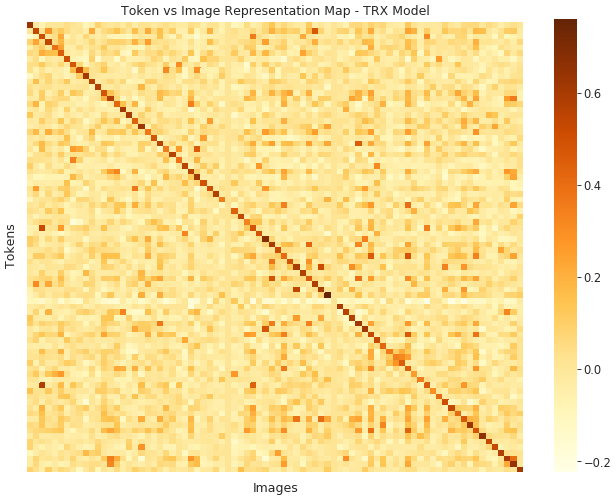

In [636]:

fig, ax = plt.subplots(1, 1, figsize = (16, 12), dpi=50)

ax = sns.heatmap(df_result[subset], annot=False
                 , cmap='YlOrBr')
bottom, top = ax.get_ylim()
print(bottom,top)
ax.set_ylim(bottom + 1.25, top - 1.25)
ax.set_title('Token vs Image Representation Map - TRX Model')
ax.tick_params(left=False, bottom=False)
ax.set(xticklabels=[]) 
ax.set(yticklabels=[]) 
ax.set_xlabel('Images')
ax.set_ylabel('Tokens')

In [629]:
np.mean(np.diag(df_result[subset]))

0.5029814578989759

In [ ]:
100  7900  tp, fp, tn, fn -- roc curve --  p, r, f
(image feature airplane[1], airplane text , apple ) [argmax]

[100,256] [4,256]

In [87]:
df_style.to_excel('../plots/imagenet_representation_results.xlsx')

In [90]:
np.unique([x[0] for x in df_result.keys()])

array(['airplane_img', 'apple_img', 'backpack_img', 'banana_img',
       'baseball bat_img', 'baseball glove_img', 'bear_img', 'bed_img',
       'bench_img', 'bicycle_img', 'bird_img', 'boat_img', 'book_img',
       'bottle_img', 'bowl_img', 'broccoli_img', 'bus_img', 'cake_img',
       'car_img', 'carrot_img', 'cat_img', 'cell phone_img', 'chair_img',
       'clock_img', 'couch_img', 'cow_img', 'cup_img', 'dining table_img',
       'dog_img', 'donut_img', 'elephant_img', 'fire hydrant_img',
       'fork_img', 'frisbee_img', 'giraffe_img', 'hair drier_img',
       'handbag_img', 'horse_img', 'hot dog_img', 'keyboard_img',
       'kite_img', 'knife_img', 'laptop_img', 'microwave_img',
       'motorcycle_img', 'mouse_img', 'orange_img', 'oven_img',
       'parking meter_img', 'person_img', 'pizza_img', 'potted plant_img',
       'refrigerator_img', 'remote_img', 'sandwich_img', 'scissors_img',
       'sheep_img', 'sink_img', 'skateboard_img', 'skis_img',
       'snowboard_img', 'spoon_im

In [194]:
# key = 'spoon_img'
# key = 'fork_img'
key = 'person_img'
# key = 'backpack_img'
# key = 'stop sign_img'

In [195]:
from scipy.special import softmax

In [196]:
df_result[key]['c_sim_mean'].values+1

array([0.9012, 0.9198, 1.1116, 0.9101, 0.979 , 1.054 , 1.0008, 0.9208,
       0.9525, 0.9697, 1.0147, 0.9619, 0.9497, 1.0325, 0.9081, 0.9541,
       0.9292, 0.9015, 0.9392, 0.9221, 0.9573, 0.9604, 0.9499, 0.9836,
       0.9453, 1.0107, 0.965 , 0.8748, 0.9227, 0.9296, 0.98  , 1.0137,
       0.9513, 0.9048, 1.0001, 1.0811, 1.122 , 0.9577, 0.9551, 0.957 ,
       0.9029, 0.9376, 0.936 , 0.9142, 0.9704, 0.8779, 0.9724, 0.9604,
       1.0039, 1.1677, 0.8811, 0.9387, 0.9805, 0.9604, 0.9472, 0.9447,
       0.9468, 0.8773, 1.0351, 0.9136, 0.9771, 0.9027, 0.9451, 0.9584,
       0.9782, 0.9446, 0.9511, 0.9231, 0.9418, 1.169 , 0.9269, 0.9271,
       0.9146, 0.9638, 0.9274, 0.9886, 1.0022, 1.0065, 0.9421, 0.9555])

In [197]:
df_result[key]['c_sim_mean'] = softmax(df_result[key]['c_sim_mean'].values+1)

In [198]:
colors = []
sim_list = df_result[key]['c_sim_mean']
max_val = sim_list.max()
for sim in sim_list:
    if max_val == sim:
        colors.append('lightgreen')
    else:
        colors.append('lightblue')

In [199]:
df_result[key]

c_sim_mean  c_sim_std       fid
airplane          0.011741     0.0751  711.2093
apple             0.011962     0.0951  681.6605
backpack          0.014491     0.1301  564.4334
banana            0.011846     0.0949  675.0417
baseball bat      0.012691     0.1015  638.1150
baseball glove    0.013680     0.1172  604.3246
bear              0.012971     0.1030  623.2722
bed               0.011974     0.0947  688.6094
bench             0.012359     0.1185  656.1677
bicycle           0.012574     0.1024  648.1066
bird              0.013153     0.0892  636.7551
boat              0.012476     0.0863  656.8726
book              0.012325     0.0967  663.0582
bottle            0.013389     0.0856  616.6562
bowl              0.011823     0.0993  688.9242
broccoli          0.012379     0.0784  670.6828
bus               0.012075     0.0900  680.6027
cake              0.011745     0.1078  681.3364
car               0.012196     0.0951  675.4820
carrot            0.011989     0.0966  663.5412
cat               0.012419     0.0910  669.9149
cell phone        0.012457     0.0820  682.7859
chair             0.012327     0.1429  658.8507
clock             0.012750     0.0731  651.4812
couch             0.012271     0.1135  661.3529
cow               0.013100     0.0954  614.5906
cup               0.012515     0.0868  647.3404
dining table      0.011435     0.0994  713.0539
dog               0.011997     0.0893  688.0072
donut             0.012080     0.0792  662.2718
elephant          0.012704     0.0951  652.3407
fire hydrant      0.013139     0.1267  602.5679
fork              0.012345     0.1006  660.2160
frisbee           0.011784     0.1113  676.5705
giraffe           0.012962     0.0674  619.0119
hair drier        0.014056     0.1695  552.1257
handbag           0.014642     0.1240  552.4574
horse             0.012424     0.1037  653.2705
hot dog           0.012392     0.0735  605.7017
keyboard          0.012415     0.0893  665.8342
kite              0.011761     0.1092  681.4873
knife             0.012177     0.0897  671.3016
laptop            0.012157     0.1018  666.5726
microwave         0.011895     0.0710  682.5694
motorcycle        0.012583     0.1077  656.5447
mouse             0.011471     0.0863  721.4462
orange            0.012608     0.0973  636.9883
oven              0.012457     0.0773  657.3165
parking meter     0.013011     0.0895  634.9670
person            0.015327     0.1335  559.4065
pizza             0.011508     0.0765  698.9415
potted plant      0.012190     0.0848  658.0701
refrigerator      0.012710     0.0779  644.0537
remote            0.012457     0.0759  677.4252
sandwich          0.012294     0.0742  661.6023
scissors          0.012263     0.0967  658.7859
sheep             0.012289     0.0974  682.6806
sink              0.011464     0.0933  721.1415
skateboard        0.013424     0.1433  617.0347
skis              0.011888     0.0836  689.0917
snowboard         0.012667     0.1107  649.7018
spoon             0.011759     0.0956  683.3382
sports ball       0.012268     0.0982  658.9825
stop sign         0.012433     0.0792  652.5680
suitcase          0.012681     0.1235  634.6034
surfboard         0.012262     0.1144  651.8598
teddy bear        0.012342     0.1153  652.7011
television        0.012001     0.1254  686.3075
tennis racket     0.012228     0.0935  655.8956
tie               0.015347     0.1933  542.6503
toaster           0.012047     0.0864  667.5221
toilet            0.012049     0.0807  685.3171
toothbrush        0.011900     0.1017  676.8660
traffic light     0.012500     0.0741  662.1802
train             0.012053     0.0754  697.6385
truck             0.012814     0.1127  650.0568
umbrella          0.012989     0.0917  626.9969
vase              0.013045     0.0952  631.5894
wine glass        0.012232     0.1072  686.4700
zebra             0.012397     0.0727  667.0195

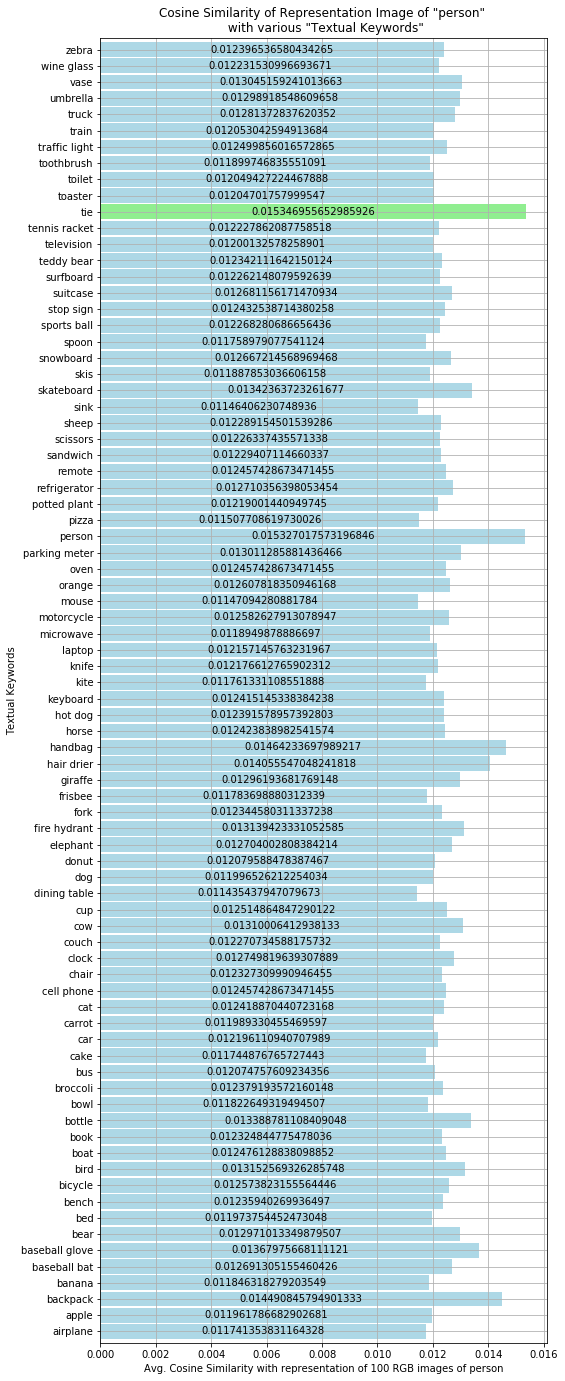

In [200]:
ax = df_result[key]['c_sim_mean'].plot(kind='barh'
                                  , color=colors
                                    ,stacked=True
                             ,figsize=(8,24)
                             ,grid=True,width=0.9
                             ,title='Cosine Similarity of Representation Image of "'+key.split('_')[0]+'" \n with various "Textual Keywords"')

ax.set_xlabel("Avg. Cosine Similarity with representation of 100 RGB images of "+key.split('_')[0])
ax.set_ylabel("Textual Keywords")
for p in ax.patches:
    left, bottom, width, height = p.get_bbox().bounds
    ax.annotate(str(width), xy=(left+width/2, bottom+height/2), 
                ha='center', va='center')

In [156]:
list(dataset.wordtoix.keys())[:10], len(dataset.wordtoix.keys())

(['<end>',
  'this',
  'metal',
  'park',
  'bench',
  'sits',
  'outside',
  'in',
  'the',
  'sun'],
 27297)

In [151]:
from sentence_transformers import SentenceTransformer

# Load the BERT model. Various models trained on Natural Language Inference (NLI) https://github.com/UKPLab/sentence-transformers/blob/master/docs/pretrained-models/nli-models.md and 
# Semantic Textual Similarity are available https://github.com/UKPLab/sentence-transformers/blob/master/docs/pretrained-models/sts-models.md

model = SentenceTransformer('bert-base-nli-mean-tokens')

In [157]:
'this is a kite'.split(' ')

['this', 'is', 'a', 'kite']

In [158]:
[dataset.wordtoix[x] for x in 'this is a kite'.split(' ')]

[1, 115, 10, 333]

In [159]:
embdding_matrix = (27297,768)
'this is a kite'

'this is a kite'

In [160]:
import transformers

In [165]:
bt = transformers.BertTokenizer()
bt.convert_tokens_to_ids(['this'])

Abuzar:
    uniter, attn gan damsm - cub dataset
    convert to bert token ids
    evaluation for one epoch

zhang:
    add code to git hub
    evaluate the current model
    overfitting - fine tuning from start 3 epochs, 6,7 hours
    CTC - ICCV
    
    /MMRL
    git status
    vim .gitignore
    
    -----
    git add .
    git commit -m "sdsdfdf"
    git push
    
Abuzar and Zhang:
    combine the models
    
Paper: 8 pages - 9 pages with ref:
    intro:
        
    related work: Dana
        sub titles 1 image captioning
        , image generation
        , multimodal matching
        , transformer
    methods: arch
        , task 1 - pretraining - damsm - loss
        , task 2 - text2img, img2text
        , multimodal joint training - loss
        , ??cycle??
        , losses - total
        --- images
    experments: 
        dataset: CUBS, COCO, Dana
        settings: lr, gpu
        task 3 - downstream: each down stream explain
        quantitative:
        qualitative:
        evaluation: - damsm, uniter, mmrl
    
    

TypeError: __init__() missing 1 required positional argument: 'vocab_file'

In [311]:
from transformers import BertTokenizer
tokenizer = BertTokenizer.from_pretrained('bert-large-uncased', do_lower=True)
max_length = 129
caption = "what is your name"
caption_encoded = tokenizer.encode_plus(
            caption, max_length=max_length, padding='max_length', return_attention_mask=True,
            return_token_type_ids=False, truncation=True)
cap_ids, cap_mask = np.array(caption_encoded['input_ids']), (1 - np.array(caption_encoded['attention_mask'])).astype(bool)

In [312]:
caption = "A curvy road"
caption_encoded = tokenizer.encode_plus(
            caption, max_length=max_length, padding='max_length', return_attention_mask=True,
            return_token_type_ids=False, truncation=True)

In [ ]:
# [15,1] -> [emb] -> [15,768] -> encoder -> [15,256], [1,256]

In [318]:
np.asarray(tokenizer.convert_ids_to_tokens(caption_encoded['input_ids']))

array(['[CLS]', 'a', 'cu', '##r', '##vy', 'road', '[SEP]', '[PAD]',
       '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]',
       '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]',
       '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]',
       '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]',
       '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]',
       '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]',
       '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]',
       '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]',
       '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]',
       '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]',
       '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]',
       '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]',
       '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]',
       '[PAD]', '[PAD]

In [204]:
cap_ids, cap_mask

(array([ 101, 2054, 2003, 2115, 2171,  102,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0]),
 array([False, False, False, False, False, False,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True, 

In [295]:
tokenizer.convert_tokens_to_ids('what')


2054

In [320]:
state_dict = \
        torch.load(cfg.TRAIN.NET_E, map_location=lambda storage, loc: storage)

In [321]:
state_dict

OrderedDict([('wemb_linear.weight',
              tensor([[-0.0426, -0.0401, -0.0039,  ..., -0.0051,  0.0625, -0.0485],
                      [-0.0868, -0.0236, -0.0143,  ...,  0.0396,  0.0877,  0.1118],
                      [ 0.0669, -0.0490,  0.0286,  ...,  0.0146,  0.0166,  0.0662],
                      ...,
                      [-0.0295,  0.0165, -0.0531,  ...,  0.0866, -0.0162, -0.0089],
                      [ 0.0053, -0.0016, -0.0169,  ..., -0.0109, -0.0315,  0.0011],
                      [ 0.0707, -0.0715,  0.0014,  ..., -0.0307,  0.0197,  0.0005]])),
             ('token_embedding.weight',
              tensor([[ 0.1113, -0.0973,  2.3203,  ..., -0.0828, -0.0947, -0.1041],
                      [-0.1467, -0.4088,  2.4978,  ...,  0.1226,  0.1386,  0.1653],
                      [ 0.3668, -0.1430,  1.5010,  ..., -0.2730, -0.0162, -0.5135],
                      ...,
                      [-0.3013, -0.2359,  2.0405,  ...,  0.0804,  0.2528, -0.1513],
                      [ 0.1

In [209]:
word2idx = {}
for key in dataset.wordtoix.keys():
    word2idx[key]=tokenizer.convert_tokens_to_ids(key)

In [297]:
tokenizer.convert_tokens_to_ids('<end>')

100

In [214]:
np.min(list(word2idx.values())),np.max(list(word2idx.values()))

(100, 29597)

In [232]:
embdding_matrix = np.zeros((29598,768),dtype=np.float32)

In [341]:
token_embedding = np.asarray(state_dict['token_embedding.weight'].detach().cpu())
print(token_embedding.shape)
token_embedding[dataset.wordtoix['curvy']],token_embedding[dataset.wordtoix['<end>']]

(27297, 768)


(array([ 2.14286409e-02, -1.13290691e+00,  6.83190167e-01,  6.84844375e-01,
        -2.37136241e-02, -2.17251331e-01, -1.40694630e+00,  3.82233262e-01,
         4.74072129e-01, -7.75224790e-02,  1.71606272e-01,  1.18519247e-01,
         2.97784090e-01,  2.23363534e-01,  1.51730657e+00,  1.15512751e-01,
        -4.98364061e-01, -3.36997181e-01,  1.49580836e-01,  3.29018421e-02,
        -2.32894421e-01, -7.74358865e-03,  8.90416130e-02, -1.29275775e+00,
        -4.65267092e-01, -1.19210994e+00,  3.25412661e-01, -1.65144771e-01,
        -5.09669125e-01, -6.23028100e-01, -2.74407715e-02, -2.23827511e-01,
         3.10023278e-01, -3.22038859e-01,  5.67301512e-01,  5.77561259e-01,
         4.85880703e-01,  2.11191680e-02,  6.13669399e-03, -1.00957966e+00,
         1.75272870e+00, -1.00469634e-01,  2.48345837e-01, -4.72601205e-02,
        -9.71187174e-01, -5.55629909e-01, -7.38678157e-01,  1.92110658e-01,
        -2.33404711e-01, -1.04205108e+00, -1.26854166e-01, -9.80082035e-01,
        -3.2

In [233]:
for k,v in word2idx.items():
    bert_id = v
    damsm_id = dataset.wordtoix[k]
    embdding_matrix[bert_id] = token_embedding[damsm_id]

In [235]:
embdding_matrix[word2idx['what']]

array([ 3.02927375e-01, -2.87254214e-01,  2.30826926e+00,  2.10747272e-01,
        4.36673313e-01,  1.07008541e+00,  3.21652174e-01,  4.59641099e-01,
       -2.93955356e-01,  1.61868110e-01, -9.23619330e-01,  1.12029694e-01,
        4.49234769e-02,  8.01292896e-01,  9.08490360e-01, -4.26732123e-01,
       -4.02044237e-01, -5.46883941e-01, -4.41669405e-01, -3.53451520e-01,
       -8.43535736e-02,  4.87706393e-01, -1.65242895e-01, -1.17519534e+00,
       -5.31409442e-01, -9.08412635e-01,  1.88279033e-01, -2.15378308e+00,
       -5.89215517e-01, -6.93413243e-02,  3.72062802e-01, -1.54754907e-01,
        7.59108841e-01,  2.43853197e-01, -5.75151324e-01,  2.12018058e-01,
       -8.49808037e-01,  1.91286355e-01,  2.17366368e-01, -2.19830647e-01,
        8.46533597e-01,  9.69425589e-02,  6.41545534e-01,  7.54416466e-01,
       -1.21749029e-01,  2.49009579e-01,  4.36335564e-01,  1.18636243e-01,
       -8.07866037e-01, -1.10000026e+00, -1.38807440e+00, -4.48602766e-01,
        6.98621333e-01,  

In [237]:
token_embedding[dataset.wordtoix['what']]

array([ 3.02927375e-01, -2.87254214e-01,  2.30826926e+00,  2.10747272e-01,
        4.36673313e-01,  1.07008541e+00,  3.21652174e-01,  4.59641099e-01,
       -2.93955356e-01,  1.61868110e-01, -9.23619330e-01,  1.12029694e-01,
        4.49234769e-02,  8.01292896e-01,  9.08490360e-01, -4.26732123e-01,
       -4.02044237e-01, -5.46883941e-01, -4.41669405e-01, -3.53451520e-01,
       -8.43535736e-02,  4.87706393e-01, -1.65242895e-01, -1.17519534e+00,
       -5.31409442e-01, -9.08412635e-01,  1.88279033e-01, -2.15378308e+00,
       -5.89215517e-01, -6.93413243e-02,  3.72062802e-01, -1.54754907e-01,
        7.59108841e-01,  2.43853197e-01, -5.75151324e-01,  2.12018058e-01,
       -8.49808037e-01,  1.91286355e-01,  2.17366368e-01, -2.19830647e-01,
        8.46533597e-01,  9.69425589e-02,  6.41545534e-01,  7.54416466e-01,
       -1.21749029e-01,  2.49009579e-01,  4.36335564e-01,  1.18636243e-01,
       -8.07866037e-01, -1.10000026e+00, -1.38807440e+00, -4.48602766e-01,
        6.98621333e-01,  

In [238]:
state_dict['token_embedding.weight'] = embdding_matrix

In [240]:
torch.save(state_dict,f='../DAMSMencoders/coco/text_encoder240_BERT_ID.pth')

In [242]:
filepath = '../data/coco/captions.pickle'
train_captions, test_captions, ixtoword, wordtoix = pd.read_pickle(filepath)

[[1, 2, 3, 4, 5, 6, 7, 8, 9],
 [10, 4, 11, 10, 12, 13, 10, 14],
 [15, 16, 17, 18, 4, 19, 7, 10, 3],
 [10, 20, 21, 22, 19, 23, 24, 25, 26],
 [10, 4, 5, 11, 10, 27, 28, 29],
 [30, 31, 32, 33, 34, 35, 36, 11, 10, 37, 38],
 [10, 39, 31, 19, 40, 28, 21, 10, 41, 42],
 [43, 31, 44, 45, 11, 8, 46, 47, 35, 48, 49, 50],
 [51, 43, 52, 53, 31, 33, 19, 7, 54, 21, 55],
 [56, 57, 39, 58, 59, 31, 33, 23, 24, 55],
 [10, 60, 61, 62, 63, 64, 65, 10, 66, 67, 10, 68],
 [10, 60, 61, 69, 63, 65, 10, 70],
 [8, 60, 61, 62, 63, 71, 65, 8, 72, 34, 73, 74],
 [10, 60, 61, 62, 63, 75, 76, 10, 63, 77],
 [10, 78, 60, 63, 11, 10, 79, 68],
 [10, 80, 81, 82, 7, 10, 83, 84, 85, 86, 34, 87],
 [88, 89, 7, 90, 7, 10, 91, 85],
 [89, 92, 93, 94, 87, 95, 10, 68, 85],
 [10, 96, 21, 89, 95, 10, 97, 98, 95, 8, 99, 85],
 [100, 89, 92, 101, 8, 83, 84, 85, 102, 8, 103],
 [10, 20, 21, 104, 105, 7, 106, 65, 10, 107, 34, 10, 108],
 [56, 104, 19, 11, 10, 106, 34, 10, 108],
 [109, 43, 80, 34, 10, 108, 58, 110, 80, 34, 10, 111, 7, 106],
 

In [281]:
len(train_captions),len(test_captions)

(413915, 202350)

In [270]:
data_dir = '../data/coco/'
filepath = '%s/%s/filenames.pickle' % (data_dir, 'test')
if os.path.isfile(filepath):
    with open(filepath, 'rb') as f:
        filenames = pickle.load(f, encoding='iso-8859-1')
    print('Load filenames from: %s (%d)' % (filepath, len(filenames)))
else:
    filenames = []
filenames

Load filenames from: ../data/coco//test/filenames.pickle (40470)


['COCO_val2014_000000412978',
 'COCO_val2014_000000412975',
 'COCO_val2014_000000243260',
 'COCO_val2014_000000452201',
 'COCO_val2014_000000391588',
 'COCO_val2014_000000391584',
 'COCO_val2014_000000147375',
 'COCO_val2014_000000380609',
 'COCO_val2014_000000318373',
 'COCO_val2014_000000007276',
 'COCO_val2014_000000384114',
 'COCO_val2014_000000007274',
 'COCO_val2014_000000456917',
 'COCO_val2014_000000130419',
 'COCO_val2014_000000007278',
 'COCO_val2014_000000216710',
 'COCO_val2014_000000088412',
 'COCO_val2014_000000488720',
 'COCO_val2014_000000309940',
 'COCO_val2014_000000488723',
 'COCO_val2014_000000424551',
 'COCO_val2014_000000424554',
 'COCO_val2014_000000307243',
 'COCO_val2014_000000136768',
 'COCO_val2014_000000132223',
 'COCO_val2014_000000016451',
 'COCO_val2014_000000506356',
 'COCO_val2014_000000506357',
 'COCO_val2014_000000274331',
 'COCO_val2014_000000268000',
 'COCO_val2014_000000542077',
 'COCO_val2014_000000280083',
 'COCO_val2014_000000542073',
 'COCO_val

In [271]:
from nltk.tokenize import RegexpTokenizer
all_captions = []
for i in tqdm_notebook(range(len(filenames))):
    cap_path = '%s/text/%s.txt' % (data_dir, filenames[i])
    with open(cap_path, "r") as f:
        captions = f.read().split('\n')
        cnt = 0
        for cap in captions:
            if len(cap) == 0:
                continue
            cap = cap.replace("\ufffd\ufffd", " ")
            # picks out sequences of alphanumeric characters as tokens
            # and drops everything else
            tokenizer = RegexpTokenizer(r'\w+')
            tokens = tokenizer.tokenize(cap.lower())
            # print('tokens', tokens)
            if len(tokens) == 0:
                print('cap', cap)
                continue

            tokens_new = []
            for t in tokens:
                t = t.encode('ascii', 'ignore').decode('ascii')
                if len(t) > 0:
                    tokens_new.append(t)
            all_captions.append(tokens_new)
            cnt += 1
            if cnt == 5:# self.embeddings_num:
                break
        if cnt < 5: # self.embeddings_num:
            print('ERROR: the captions for %s less than %d'
                  % (filenames[i], cnt))

cap .
cap .
cap .
cap  
cap  
cap  
cap .
cap  
cap  
cap .
cap .



In [274]:
test_captions_new = []
for t in tqdm_notebook(all_captions):
    rev = []
    for w in t:
        if w in wordtoix:
            rev.append(word2idx[w])
    # rev.append(0)  # do not need '<end>' token
    test_captions_new.append(rev)

In [279]:
len(train_captions_new)

413915

In [280]:
len(test_captions_new)

202350

In [290]:
idx2word = {}
for k,v in word2idx.items():
    if v in idx2word.keys():
        print(v)
    else:
        idx2word[v]=k

100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100


100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100


100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100


100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100


100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100


In [345]:
for k,v in dataset.wordtoix.items():
    if '<' in k:
        print(k)

<end>


In [291]:
word2idx

{'<end>': 100,
 'this': 2023,
 'metal': 3384,
 'park': 2380,
 'bench': 6847,
 'sits': 7719,
 'outside': 2648,
 'in': 1999,
 'the': 1996,
 'sun': 3103,
 'a': 1037,
 'on': 2006,
 'sidewalk': 11996,
 'underneath': 7650,
 'tree': 3392,
 'curvy': 100,
 'long': 2146,
 'ended': 3092,
 'designer': 5859,
 'sitting': 3564,
 'couple': 3232,
 'of': 1997,
 'benches': 19571,
 'next': 2279,
 'to': 2000,
 'each': 2169,
 'other': 2060,
 'cement': 11297,
 'side': 2217,
 'walk': 3328,
 'railway': 2737,
 'train': 3345,
 'passenger': 4628,
 'cars': 3765,
 'with': 2007,
 'graffiti': 17990,
 'parked': 9083,
 'gravel': 11127,
 'lot': 2843,
 'blue': 2630,
 'along': 2247,
 'green': 2665,
 'forest': 3224,
 'old': 2214,
 'left': 2187,
 'out': 2041,
 'ground': 2598,
 'has': 2038,
 'all': 2035,
 'over': 2058,
 'it': 2009,
 'very': 2200,
 'oddly': 15056,
 'colored': 6910,
 'front': 2392,
 'trees': 3628,
 'two': 2048,
 'abandoned': 4704,
 'and': 1998,
 'white': 2317,
 'red': 2417,
 'double': 3313,
 'decker': 20946,
 

In [ ]:
with open('../data/coco/bert_based_captions.pickle','wb') as f:
    pickle.dump([train_captions_new, test_captions_new,idx2word, wordtoix], f, protocol=2)

In [338]:
model.encode('sizzor')model.encode('neckties')

(array([-7.66443834e-02, -3.72737586e-01,  2.09336758e+00,  3.10124546e-01,
         1.78275332e-01,  6.55618489e-01, -2.97862947e-01,  6.22633338e-01,
         2.44372129e-01, -7.45039731e-02, -6.14759564e-01,  4.59028810e-01,
         5.01017928e-01,  5.16781449e-01,  6.57776475e-01,  3.91100347e-01,
        -9.07786191e-01, -2.55965054e-01,  7.05094635e-01, -8.73058319e-01,
         2.56089985e-01,  6.85098886e-01, -1.81351706e-01, -8.17346752e-01,
        -1.24787927e-01, -3.84812832e-01,  2.35238865e-01, -1.90267909e+00,
        -3.64018261e-01, -2.37520970e-02,  4.22515497e-02, -3.08613688e-01,
         4.05252278e-01, -2.32367426e-01, -3.42244864e-01,  6.21017456e-01,
        -5.69836438e-01,  1.79487661e-01, -4.47285585e-02, -2.40594789e-01,
         1.41281056e+00, -3.41933593e-02,  9.73407149e-01,  1.43391281e-01,
        -9.04291034e-01,  7.93509483e-02, -5.79918995e-02, -1.84095874e-01,
        -2.67092288e-01, -1.26396012e+00, -7.20338881e-01, -5.80517411e-01,
         5.9

In [332]:
w2i_df = pd.DataFrame.from_dict(word2idx,orient='index').reset_index()

In [333]:
w2i_df.columns = ['word','id']

In [335]:

w2i_df = w2i_df.sort_values(by='id',ascending=True)

In [336]:
w2i_df[w2i_df['id']==100]

word   id
0           <end>  100
17137    harbored  100
17136     waiving  100
17135   paraskier  100
17134    beaneath  100
...           ...  ...
10879    neckties  100
10880      sizzor  100
10099        peep  100
11134       roomy  100
11132  partitions  100

[15270 rows x 2 columns]